# Monk2
Grid Search for Monk2 dataset model selection


In [30]:
from exclusiveAI.components.Validation.HoldOut import parallel_hold_out, hold_out
from exclusiveAI.ConfiguratorGen import ConfiguratorGen
from exclusiveAI.datasets.monk import read_monk2
from exclusiveAI.utils import one_hot_encoding
from exclusiveAI.Composer import Composer
from tqdm import tqdm
import pandas as pd
import numpy as np
from exclusiveAI.utils import plot_history
import os, json

#### Read Monk2 dataset 

In [31]:
training_data, training_labels, test_data, test_labels = read_monk2("../exclusiveAI/datasets/")

One-Hot Encoding Training Dataset

In [32]:
training_data = one_hot_encoding(training_data)

One-Hot Encoding Test Dataset

In [33]:
test_data = one_hot_encoding(test_data)

Getting the (most interesting) models from the big grid search 

In [34]:
def read_json_files(my_dir_path):
        data = pd.DataFrame()
        for file in os.listdir(my_dir_path):
            if file.endswith('.json'):
                with open(os.path.join(my_dir_path, file), 'r') as f:
                    my_data = [data['0'] for data in json.load(f).values()]
                    data = pd.concat([data,  pd.DataFrame(my_data)], ignore_index=True, axis=0)
        return data
batch_size = 32
epochs = 500

if not os.path.exists('monk2_models_configs.json'):
    dir_path = "Monk2/"
    
    all_json_data = read_json_files(dir_path)
    regularizations = all_json_data['regularization'].unique().tolist()
    learning_rates = all_json_data['learning_rate'].unique().tolist()
    [learning_rates.insert(i, el) for i, el in enumerate(np.arange(0.1, 0.8, 0.1))]
    momentums = all_json_data['momentum'].unique().tolist()
    num_of_layers = all_json_data['num_layers'].unique().tolist()
    num_of_units = set([unit1 for unit in all_json_data['num_of_units'] for unit1 in unit])
    initializers = ["uniform", "gaussian"]
    activations = ["sigmoid"]
    
    myConfigurator = ConfiguratorGen(random=False, learning_rates=learning_rates, regularizations=regularizations,
                                     loss_function=['mse'], optimizer=['sgd'],
                                     activation_functions=activations,
                                     number_of_units=num_of_units, number_of_layers=num_of_layers,
                                     momentums=momentums, initializers=initializers,
                                     input_shapes=training_data.shape,
                                     verbose=False, nesterov=True,
                                     callbacks=["earlystopping"], output_activation='sigmoid', show_line=False,
                                     ).get_configs()
    len(myConfigurator)
    
    configs=[]
    if __name__ == '__main__':
        configs.append(
            parallel_hold_out(myConfigurator, training=training_data, training_target=training_labels, epochs=epochs,
                              batch_size=batch_size, num_models=10, workers=8, number_of_initializations=5,
                              ))
    
        configs = pd.DataFrame(configs)
        # Save as json
        configs.to_json('monk2_models_configs.json')
else: 
    with open('monk2_models_configs.json', 'r') as f:
        configs = [data['0'] for data in json.load(f).values()]

In [35]:
models = []
with tqdm(total=len(configs)) as pbar:
    for config in configs:
        model = Composer(config=config).compose()
        model.train(inputs=training_data, input_label=training_labels, epochs=epochs, batch_size=batch_size, name=config['model_name'], disable_line=True)
        test_val = model.evaluate(input=test_data, input_label=test_labels)
        models.append((model.get_last()['mse'], np.std(np.array(model.history['mse'])), model.get_last()['binary_accuracy'], test_val[0], test_val[1], model.curr_epoch, model.history['mee'], Composer(config=config).compose(), config, config['num_layers'], config['num_of_units'], config['model_name']))
        pbar.update(1)

# Convert the list of tuples to a DataFrame with one column for each element in the tuple
df = pd.DataFrame(models, columns=['Score', 'History_Std', 'Accuracy', 'Test_Score', 'Test_Accuracy', 'Trained_Epochs', 'History', 'Model', 'Config', 'Num_Layers', 'Num_of_Units', 'Name'])

100%|██████████| 100/100 [00:11<00:00,  8.49it/s]


In [36]:
# Sort the DataFrame by the first element in the tuple (column 'Value')

df_sorted = df.sort_values(by=['Num_Layers', 'History_Std', 'Score', 'Test_Score'])
df_sorted = df_sorted[df_sorted['Accuracy'] >= 1]
df_sorted = df_sorted[df_sorted['Test_Accuracy'] >= 1]
df_sorted = df_sorted[df_sorted['History_Std'] <= 0.08]
df_sorted = df_sorted[df_sorted['Test_Score'] <= 0.01]
# df_sorted = df_sorted[df_sorted['Num_Layers'] <= 1]
# df_sorted['Num_of_Units'] = [value[0] for value in df_sorted['Num_of_Units']]
# df_sorted = df_sorted[df_sorted['Num_of_Units'] == 4]
histories = {row[0]: row[1] for row in df_sorted[['Name', 'History']].values}
df_sorted

,Score,History_Std,Accuracy,Test_Score,Test_Accuracy,Trained_Epochs,History,Model,Config,Num_Layers,Num_of_Units,Name
8,0.001242,0.069568,1.0,0.002434,1.0,200,"[0.46680137469934496, 0.45746964745261826, 0.4...",<exclusiveAI.components.NeuralNetwork.NeuralNe...,"{'regularization': 0.0, 'learning_rate': 0.84,...",1,[4],Model45103
36,0.000942,0.070189,1.0,0.001140,1.0,181,"[0.44172178760143066, 0.4927411236010691, 0.46...",<exclusiveAI.components.NeuralNetwork.NeuralNe...,"{'regularization': 0.0, 'learning_rate': 0.84,...",1,[4],Model42375
51,0.000810,0.072040,1.0,0.000949,1.0,154,"[0.5090007560755695, 0.4482516518182131, 0.468...",<exclusiveAI.components.NeuralNetwork.NeuralNe...,"{'regularization': 0.0, 'learning_rate': 0.84,...",1,[4],Model41743
39,0.000973,0.073234,1.0,0.001159,1.0,172,"[0.4379411491901641, 0.4837848907086068, 0.478...",<exclusiveAI.components.NeuralNetwork.NeuralNe...,"{'regularization': 0.0, 'learning_rate': 0.84,...",1,[4],Model42222
31,0.001088,0.075162,1.0,0.001244,1.0,200,"[0.4596167605006047, 0.4696473958563057, 0.463...",<exclusiveAI.components.NeuralNetwork.NeuralNe...,"{'regularization': 0.0, 'learning_rate': 0.84,...",1,[4],Model43015
75,0.000662,0.075389,1.0,0.000805,1.0,134,"[0.4634280970888931, 0.47377384002189993, 0.46...",<exclusiveAI.components.NeuralNetwork.NeuralNe...,"{'regularization': 0.0, 'learning_rate': 0.84,...",1,[4],Model40935
14,0.001671,0.076881,1.0,0.001950,1.0,200,"[0.4089113735941091, 0.45671050387239037, 0.46...",<exclusiveAI.components.NeuralNetwork.NeuralNe...,"{'regularization': 0.0, 'learning_rate': 0.84,...",1,[3],Model44621
40,0.000966,0.077343,1.0,0.001206,1.0,188,"[0.5493096435349583, 0.4592058253423136, 0.452...",<exclusiveAI.components.NeuralNetwork.NeuralNe...,"{'regularization': 0.0, 'learning_rate': 0.84,...",1,[3],Model42213
95,0.000520,0.077422,1.0,0.000644,1.0,105,"[0.5213347392540253, 0.43123781897987873, 0.48...",<exclusiveAI.components.NeuralNetwork.NeuralNe...,"{'regularization': 0.0, 'learning_rate': 0.84,...",1,[4],Model40463
61,0.000711,0.077862,1.0,0.000810,1.0,144,"[0.45307828952632784, 0.4680912698042736, 0.46...",<exclusiveAI.components.NeuralNetwork.NeuralNe...,"{'regularization': 0.0, 'learning_rate': 0.84,...",1,[3],Model41252


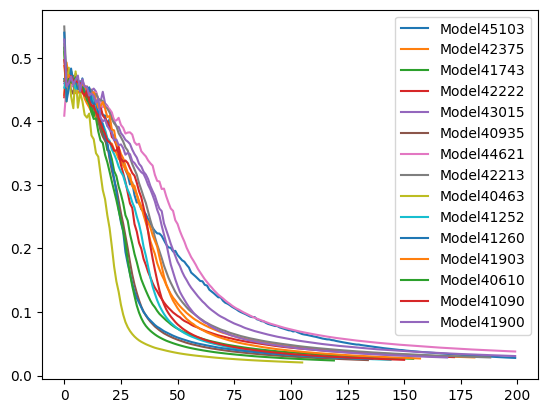

In [37]:
plot_history(histories)
# plot_history({"Model43652": -np.sort(-np.array(histories["Model43652"]))})
